In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_distributions(qy0, py0, num_samples=1000):
    # Generate samples from both distributions
    qy0_samples = qy0.sample((num_samples,))
    py0_samples = py0.sample((num_samples,))
    
    # Convert to numpy for plotting
    qy0_samples = qy0_samples.detach().numpy()
    py0_samples = py0_samples.detach().numpy()

    # Assume dimensions from the shape of samples
    num_dims = qy0_samples.shape[1]

    # Plotting using matplotlib and seaborn
    fig, axes = plt.subplots(nrows=num_dims, figsize=(10, num_dims * 5))
    if num_dims == 1:
        axes = [axes]  # Make it iterable
    
    for i, ax in enumerate(axes):
        sns.histplot(qy0_samples[:, i], kde=True, stat="density", color="blue", label="qy0 (Posterior)", ax=ax)
        sns.histplot(py0_samples[:, i], kde=True, stat="density", color="red", alpha=0.6, label="py0 (Prior)", ax=ax)
        ax.set_title(f'Distribution of Dimension {i+1}')
        ax.legend()

    plt.tight_layout()
    plt.show()

/Users/riccardoconci/miniconda3/envs/CompTest/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


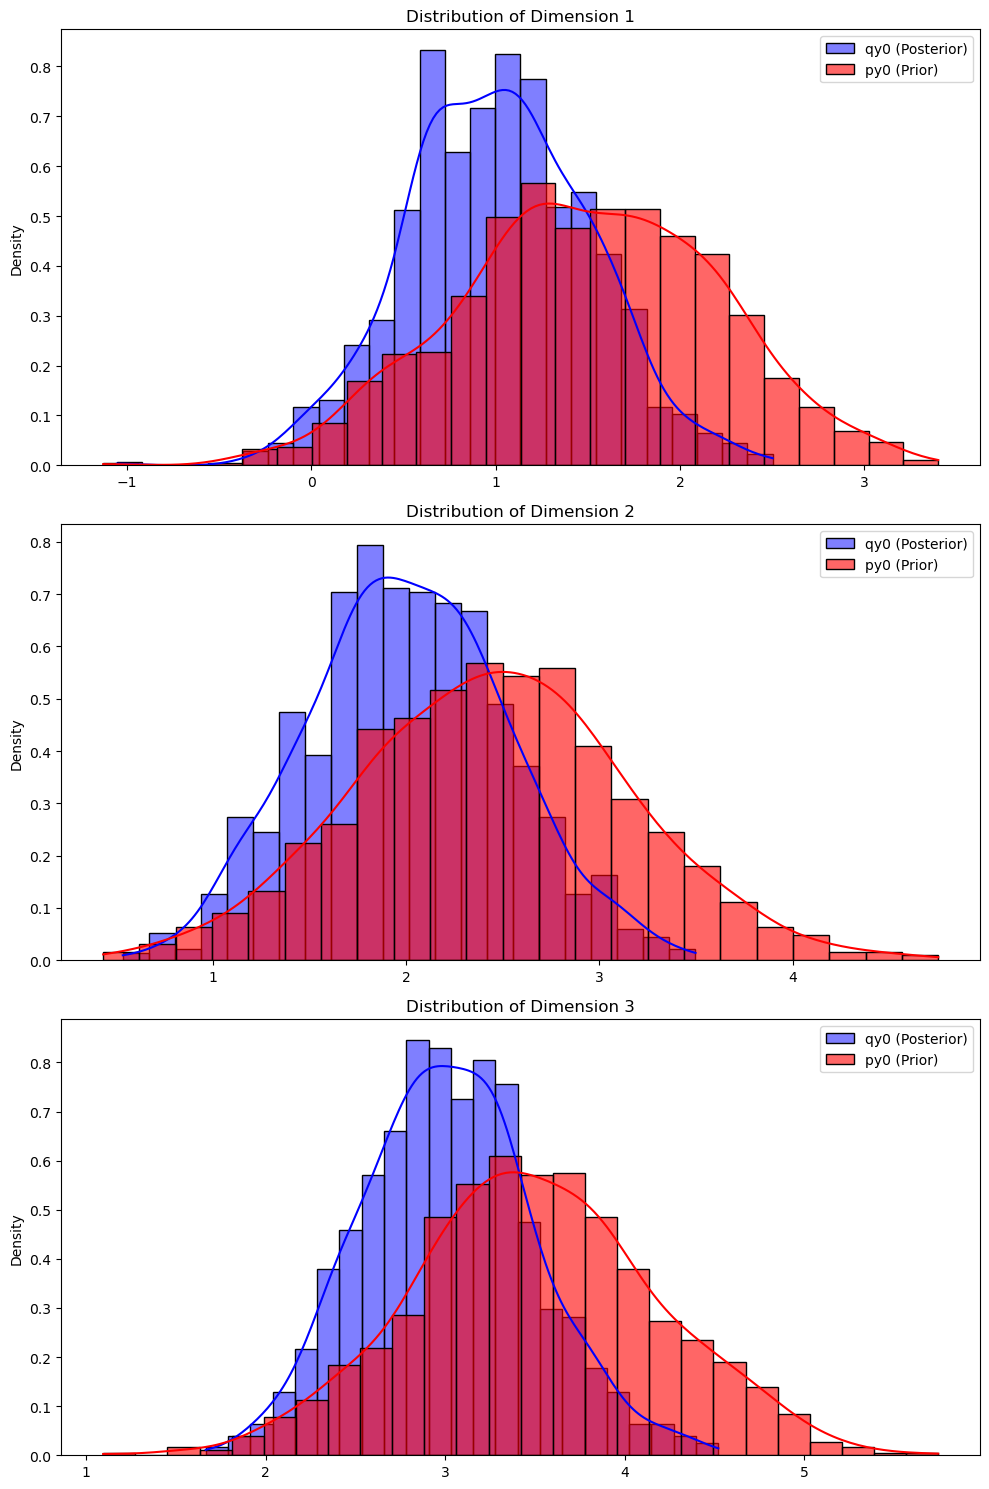

In [2]:
# Sample mean and std tensors for 3 dimensions
mean_qy0 = torch.tensor([1.0, 2.0, 3.0])
std_qy0 = torch.tensor([0.5, 0.5, 0.5])
mean_py0 = torch.tensor([1.5, 2.5, 3.5])
std_py0 = torch.tensor([0.7, 0.7, 0.7])

# Create the Normal distributions
qy0 = torch.distributions.Normal(loc=mean_qy0, scale=std_qy0)
py0 = torch.distributions.Normal(loc=mean_py0, scale=std_py0)

# Use the visualization function
visualize_distributions(qy0, py0)

In [13]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import torch
import numpy as np

class MockModel:
    def __init__(self, train_dir=".", log_wandb=False):
        self.train_dir = train_dir
        self.log_wandb = log_wandb

    def plot_trajectories(self, predicted_traj, true_traj, k=3):
        idx = np.random.choice(predicted_traj.shape[0], k, replace=False)
        num_dims = true_traj.shape[2]

        fig = make_subplots(rows=k, cols=1, subplot_titles=[f'Batch {i+1}' for i in range(k)])

        for i, b in enumerate(idx):
            for d in range(num_dims):
                pred_samples = predicted_traj[b, :, :, d].detach().cpu().numpy()
                true_values = true_traj[b, :, d].detach().cpu().numpy()
                lower_bound = np.min(pred_samples, axis=0)
                upper_bound = np.max(pred_samples, axis=0)
                times = np.arange(pred_samples.shape[1])

                # Concatenate for plotly area plot (shaded region for prediction bounds)
                fig.add_trace(
                    go.Scatter(
                        x=np.concatenate([times, times[::-1]]),
                        y=np.concatenate([upper_bound, lower_bound[::-1]]),
                        fill='toself',
                        fillcolor=f'rgba(0,100,80,{0.2 if d == 0 else 0.1})',  # vary opacity by dimension
                        line=dict(color='rgba(255,255,255,0)'),
                        showlegend=False,
                        legendgroup=f'Batch {b}',
                        name=f'Bounds Dim {d+1}'
                    ),
                    row=i+1, col=1
                )

                # True trajectory
                fig.add_trace(
                    go.Scatter(
                        x=times, y=true_values, mode='lines+markers',
                        line=dict(color='blue', width=2),
                        marker=dict(size=4, color='red'),
                        name=f'True Trajectory Dim {d+1}',
                        legendgroup=f'Batch {b}',
                    ),
                    row=i+1, col=1
                )

        fig.update_layout(
            height=300*k,  # Adjust height based on the number of batches
            title=f'Trajectories Comparison Across Batches',
            showlegend=True
        )
        fig.show()

# Assuming the instantiation and method call are done as before

# Assuming the instantiation and method call are done as before

# Generate mock data
batch, samples, times, dim = 5, 10, 100, 2  # Configuration
t = torch.linspace(0, 6 * torch.pi, times)  # Time axis

# Reshape t for broadcasting
t_reshaped = torch.sin(t).unsqueeze(0).unsqueeze(-1).repeat(batch, 1, dim)  # Adjusted reshaping for true_traj
t_reshaped_pred = torch.cos(t).unsqueeze(0).unsqueeze(0).unsqueeze(-1)

predicted_traj = t_reshaped_pred + 0.1 * torch.randn(batch, samples, times, dim)  # Small noise around true values
true_traj = t_reshaped  # Simplified true_traj assignment

# Example usage
model = MockModel(train_dir='your_directory', log_wandb=False)
model.plot_trajectories(predicted_traj, true_traj, k=3)